In [69]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import models.simpleConv as simpleConv
from imgaug import augmenters as iaa

import h5py
from imgaug import augmenters as iaa
from keras.utils import np_utils

import utils
import preprocessing as pp
pp.init()

allTrainingFolders = [x for x in os.listdir(pp.trainPath) if x.startswith('n')]
trainingFolders = allTrainingFolders[0:100]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Checking to make sure output directories are created..
..done


# Parsing & Data Loading & Model Fitting

In [70]:
encoder = LabelBinarizer()
##MAKE SURE classLabels is set to ALL the folders you will train on, even if doing in batches
encoder = encoder.fit(trainingFolders) 

parse = True
train = True
saveModel = True
includeAugmented = False
onlyAugmented = False

augments = [iaa.GaussianBlur(3.0)]
h5filename = 'all100.h5'

if parse:
    if os.path.isfile(os.path.join(pp.h5Path, h5filename)):
        os.remove(os.path.join(pp.h5Path, h5filename))
    pp.parseImages(trainingFolders, h5filename)
    
#NOTE: KEEP BATCH SIZE = # of all folders for now because we need to shuffle H5. 


callbacks = []
epochs = 10

model = simpleConv.build_model(len(encoder.classes_), pp.img_width, pp.img_height, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

all_x_val = []
all_y_val = []
all_x_train = []
all_y_train = []

# x_train, y_train, x_val, y_val = pp.loadH5(h5filename)


f = h5py.File(os.path.join(pp.h5Path, h5filename), 'r')
train_x = f['x_train']
train_y = f['y_train']
val_x = f['x_val']
val_y = f['y_val']

batch_size = 50



##FIT MODEL
if train:
    for epoch in range(0, epochs):
        print("Epoch Number: ", epoch)
        idxs = np.random.permutation(len(train_x))
        batches = utils.chunks(idxs, batch_size)
        batches_sorted = [np.sort(b) for b in batches]

        print("training for {0} batches".format(len(batches_sorted)))
        batch_num = 0
        for batch in batches_sorted:
            batch_num +=1

            x_train = train_x[list(batch)]
            y_train = train_y[list(batch)]
            y_train = [y.decode('utf-8') for y in y_train]



            x_aug = []
            y_aug = []
            if includeAugmented:
                x_aug, y_aug = pp.augmentData(x_train, y_train, augments = augments)
                if onlyAugmented:
                    x_train = x_aug
                    y_train = y_aug
                else:
                    x_train.extend(x_aug)
                    y_train.extend(y_aug)

            y_train = encoder.transform(y_train) #call encoder.inverse_transform() to get real class labels



    #         model.train_on_batch(np.array(x_train), np.array(y_train))
    #         results = model.fit(np.array(x_train), np.array(y_train), 
    #                     validation_data = (np.array(x_val), np.array(y_val)),
    #                     epochs=epochs, verbose=1, callbacks = callbacks)

            results = model.fit(np.array(x_train), np.array(y_train),
                epochs=1, callbacks = callbacks, )

        if saveModel:
            count = 1
            outputName = ""
            while True:
                k = ''
                if includeAugmented:
                    k = 'with-aug'
                if onlyAugmented:
                    k = 'aug-only'
                s = pp.baseModelName.format(epoch, count, k) + ".h5" 
                if not s in os.listdir(pp.outputModelPath):         
                    outputName = s         
                    break     
                else:         
                    count+=1 
            print(outputName)
            model.save(os.path.join(pp.outputModelPath, outputName))


Parsing images for class ID: n01440764. Found 454 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01443537. Found 648 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01484850. Found 530 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01491361. Found 485 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01494475. Found 472 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01496331. Found 465 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01498041. Found 501 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01514668. Found 584 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01514859. Found 495 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01518878. Found 512 image

Parsing images for class ID: n01776313. Found 568 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01784675. Found 652 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01795545. Found 428 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01796340. Found 573 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01797886. Found 466 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01798484. Found 452 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01806143. Found 519 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01806567. Found 494 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01807496. Found 466 images. 
Writing to h5 file: output\image-h5\all100.h5
Parsing images for class ID: n01817953. Found 576 image

50/50 [==============================] - 0s 2ms/step - loss: 4.3767 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5611 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.4376 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5673 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.3838 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.4391 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5998 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5458 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5613 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5400 - acc: 0.0000e+00
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5555 - acc: 0

50/50 [==============================] - 0s 2ms/step - loss: 4.1693 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.3836 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2903 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2812 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2136 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.4378 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.3367 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2073 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5632 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.3367 - acc: 0.0000e+00
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.3697 - acc: 0

50/50 [==============================] - 0s 2ms/step - loss: 4.1923 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.1999 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2019 - acc: 0.0000e+00
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.5800 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0404 - acc: 0.1000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2388 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.4226 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0205 - acc: 0.1000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0630 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2614 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0865 - acc: 0

50/50 [==============================] - 0s 2ms/step - loss: 3.9280 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0426 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9827 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9691 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9894 - acc: 0.1000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0105 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9655 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.1256 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0326 - acc: 0.0200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2345 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9178 - acc: 0.100

50/50 [==============================] - 0s 2ms/step - loss: 4.0615 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9165 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.1893 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8949 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9906 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.1719 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2643 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0909 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2085 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9901 - acc: 0.1000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.0853 - acc: 0.040

50/50 [==============================] - 0s 2ms/step - loss: 3.8701 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9739 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9133 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8340 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8559 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.1064 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8124 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9439 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7668 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5215 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7652 - acc: 0.060

50/50 [==============================] - 0s 2ms/step - loss: 3.5589 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9115 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6347 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6968 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5251 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9093 - acc: 0.1000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7205 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8211 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7524 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5413 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8029 - acc: 0.120

50/50 [==============================] - 0s 2ms/step - loss: 3.6944 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9835 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8581 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8040 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8297 - acc: 0.1000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6065 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8222 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7508 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.9046 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6032 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6261 - acc: 0.140

50/50 [==============================] - 0s 2ms/step - loss: 3.4664 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 4.2734 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.4843 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 3.6351 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7730 - acc: 0.0600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8938 - acc: 0.0800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5412 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5799 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6953 - acc: 0.0400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6938 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6363 - acc: 0.140

50/50 [==============================] - 0s 2ms/step - loss: 3.4632 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0683 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0544 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3243 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.8029 - acc: 0.1000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5874 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5863 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6078 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6381 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2680 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2317 - acc: 0.260

50/50 [==============================] - 0s 2ms/step - loss: 3.5712 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.4087 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7030 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3189 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.4694 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.4060 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1826 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3786 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2020 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2074 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3337 - acc: 0.180

50/50 [==============================] - 0s 2ms/step - loss: 3.8114 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6571 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2059 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3137 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6334 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3167 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6112 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3276 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1083 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.4007 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7810 - acc: 0.100

50/50 [==============================] - 0s 2ms/step - loss: 3.6305 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2367 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6000 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2500 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2017 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3792 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3462 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3469 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2371 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3360 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5980 - acc: 0.120

50/50 [==============================] - 0s 2ms/step - loss: 3.2158 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6029 - acc: 0.1000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3631 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1440 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1754 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2148 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.7198 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.6488 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.4149 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2731 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2268 - acc: 0.200

50/50 [==============================] - 0s 2ms/step - loss: 3.4349 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5189 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2635 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1686 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3253 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3154 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8183 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8604 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8561 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1981 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0814 - acc: 0.300

50/50 [==============================] - 0s 2ms/step - loss: 3.0441 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1613 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2316 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5461 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1652 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 3.3341 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.4800 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2632 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1296 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0427 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9137 - acc: 0.340

50/50 [==============================] - 0s 2ms/step - loss: 2.8251 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1841 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3996 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2713 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0588 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9780 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2070 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2812 - acc: 0.1400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3231 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0296 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8857 - acc: 0.240

50/50 [==============================] - 0s 2ms/step - loss: 2.8356 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0261 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 3.0807 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1846 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1809 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2064 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5231 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1829 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7486 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7211 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2187 - acc: 0.240

50/50 [==============================] - 0s 2ms/step - loss: 3.2413 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1971 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2818 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8742 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8539 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0595 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2394 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9753 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0528 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3281 - acc: 0.1600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.4471 - acc: 0.160

50/50 [==============================] - 0s 2ms/step - loss: 3.0026 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9821 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6955 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4524 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3370 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5837 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7113 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5314 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5603 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8825 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4759 - acc: 0.320

50/50 [==============================] - 0s 2ms/step - loss: 2.7566 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7072 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5425 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5545 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7971 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0513 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9699 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8437 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9484 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0441 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.5799 - acc: 0.240

50/50 [==============================] - 0s 2ms/step - loss: 2.7027 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6452 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0976 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7084 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1542 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9982 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9697 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7504 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9769 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1429 - acc: 0.280

50/50 [==============================] - 0s 2ms/step - loss: 2.3309 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.2780 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8482 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9406 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8624 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5612 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8974 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5264 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1969 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4932 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7301 - acc: 0.320

50/50 [==============================] - 0s 2ms/step - loss: 3.0715 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7888 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9325 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9377 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3317 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6906 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1725 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5944 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8349 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8023 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5937 - acc: 0.400

50/50 [==============================] - 0s 2ms/step - loss: 2.2561 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7512 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0463 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7888 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3470 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9786 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8261 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7674 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.3063 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5373 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2995 - acc: 0.400

50/50 [==============================] - 0s 2ms/step - loss: 3.0373 - acc: 0.1200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1435 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7276 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7898 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2932 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6498 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9554 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1445 - acc: 0.2200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6671 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8357 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0546 - acc: 0.300

50/50 [==============================] - 0s 2ms/step - loss: 2.7914 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9838 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5303 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8289 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5183 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7964 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8602 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9018 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9517 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0512 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.1213 - acc: 0.260

50/50 [==============================] - 0s 2ms/step - loss: 2.7042 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5439 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4659 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0649 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9877 - acc: 0.2400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5660 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5693 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6040 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8906 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.9283 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7869 - acc: 0.280

50/50 [==============================] - 0s 2ms/step - loss: 2.7930 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2868 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9308 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1567 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5694 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1861 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4881 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1414 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0715 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5233 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0180 - acc: 0.460

50/50 [==============================] - 0s 2ms/step - loss: 2.0676 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2212 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1409 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3666 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0932 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4581 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2467 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7042 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6530 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 3.0063 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6750 - acc: 0.300

50/50 [==============================] - 0s 2ms/step - loss: 2.5104 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6832 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7353 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1718 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1613 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5197 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4486 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4553 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3472 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7443 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5618 - acc: 0.280

50/50 [==============================] - 0s 2ms/step - loss: 2.4560 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4218 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6928 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5874 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1772 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8572 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9777 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9920 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5132 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5637 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5800 - acc: 0.380

50/50 [==============================] - 0s 2ms/step - loss: 2.2882 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1999 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2326 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2949 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4112 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9276 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6312 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2467 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4825 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0917 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4463 - acc: 0.420

50/50 [==============================] - 0s 2ms/step - loss: 2.4539 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3732 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3627 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8313 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4354 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7384 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2606 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5467 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2391 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7537 - acc: 0.2600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3104 - acc: 0.460

50/50 [==============================] - 0s 2ms/step - loss: 2.6130 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3864 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9393 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4012 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.8257 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1690 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7673 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1932 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3449 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3984 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4262 - acc: 0.480

50/50 [==============================] - 0s 2ms/step - loss: 2.2806 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2444 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6760 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4649 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0688 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6504 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6708 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7374 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5639 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2425 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0152 - acc: 0.440

50/50 [==============================] - 0s 2ms/step - loss: 2.3372 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0464 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5593 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6720 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7550 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9869 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7018 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1681 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7753 - acc: 0.2800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1408 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7992 - acc: 0.340

50/50 [==============================] - 0s 2ms/step - loss: 2.6995 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2128 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2284 - acc: 0.4200
Epoch 1/1
8/8 [==============================] - 0s 4ms/step - loss: 2.6574 - acc: 0.1250
model-3-1-.h5
Epoch Number:  4
training for 838 batches
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2874 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3021 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1752 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3988 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9189 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0954 - acc: 0.4800
Epoch 1/1
50/50 [===================

50/50 [==============================] - 0s 2ms/step - loss: 2.3754 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8218 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5760 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1146 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0310 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4288 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0436 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8850 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1772 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5980 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9021 - acc: 0.560

50/50 [==============================] - 0s 2ms/step - loss: 2.0263 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.5053 - acc: 0.3000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0941 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1303 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3659 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0874 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0340 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1781 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7644 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2245 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0774 - acc: 0.480

50/50 [==============================] - 0s 2ms/step - loss: 1.7111 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1466 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8045 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0105 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0666 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6396 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9022 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0918 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7860 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0485 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8025 - acc: 0.520

50/50 [==============================] - 0s 2ms/step - loss: 1.9302 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8574 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1750 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7965 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0434 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2363 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7667 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3089 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2135 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0446 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1638 - acc: 0.440

50/50 [==============================] - 0s 2ms/step - loss: 1.9023 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0260 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8986 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2091 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9164 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8580 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1160 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2156 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.7208 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6304 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8609 - acc: 0.480

50/50 [==============================] - 0s 2ms/step - loss: 1.9623 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9069 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1277 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2813 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2211 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6014 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0286 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7943 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9986 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0915 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1446 - acc: 0.360

50/50 [==============================] - 0s 2ms/step - loss: 2.0562 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0669 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9674 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3320 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6932 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1658 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8928 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9865 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.4013 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3224 - acc: 0.3200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9290 - acc: 0.460

50/50 [==============================] - 0s 2ms/step - loss: 2.2169 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8061 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1856 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9623 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1892 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0629 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1285 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1150 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.3210 - acc: 0.4000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0504 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9224 - acc: 0.460

50/50 [==============================] - 0s 2ms/step - loss: 2.3664 - acc: 0.3400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1828 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1226 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2441 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9693 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7220 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2054 - acc: 0.3600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1366 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0223 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0186 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0564 - acc: 0.420

50/50 [==============================] - 0s 2ms/step - loss: 1.3076 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4215 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3984 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9549 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3014 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6290 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 1.3352 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3727 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5839 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2047 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5200 - acc: 0.560

50/50 [==============================] - 0s 2ms/step - loss: 1.4583 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7471 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4500 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9144 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8684 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2523 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1939 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4035 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0615 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5864 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5791 - acc: 0.520

50/50 [==============================] - 0s 2ms/step - loss: 1.8210 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6061 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5273 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0587 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8675 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3009 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4702 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4490 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7078 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6267 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6747 - acc: 0.520

50/50 [==============================] - 0s 2ms/step - loss: 1.5892 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4006 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0723 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6560 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5679 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8927 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4695 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7939 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6018 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8324 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4733 - acc: 0.540

50/50 [==============================] - 0s 2ms/step - loss: 1.8829 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6104 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4965 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5390 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4571 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3894 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3355 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5192 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5091 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4815 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5286 - acc: 0.480

50/50 [==============================] - 0s 2ms/step - loss: 1.7408 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.2123 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5193 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8855 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8646 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8470 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0653 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0429 - acc: 0.4200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6065 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6393 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7542 - acc: 0.400

50/50 [==============================] - 0s 2ms/step - loss: 1.1978 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5532 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5022 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6980 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9797 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6528 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8634 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9261 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4075 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8889 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4262 - acc: 0.580

50/50 [==============================] - 0s 2ms/step - loss: 1.3559 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3016 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6171 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6788 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7462 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5496 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6509 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7708 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6377 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3463 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6221 - acc: 0.580

50/50 [==============================] - 0s 2ms/step - loss: 1.8418 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.8253 - acc: 0.4400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5492 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2228 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6016 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.9945 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7004 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4341 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.1215 - acc: 0.3800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.0799 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5796 - acc: 0.660

50/50 [==============================] - 0s 2ms/step - loss: 1.2698 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8484 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9997 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0598 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9690 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0770 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2565 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7254 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8319 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1661 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5973 - acc: 0.580

50/50 [==============================] - 0s 2ms/step - loss: 1.4446 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3680 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0995 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5357 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3942 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1711 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0034 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0453 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2958 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9072 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0819 - acc: 0.680

50/50 [==============================] - 0s 2ms/step - loss: 1.1957 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3444 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1365 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0126 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2170 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5669 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0376 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2085 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1170 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0301 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1487 - acc: 0.680

50/50 [==============================] - 0s 2ms/step - loss: 1.1143 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9748 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0138 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2666 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3146 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2936 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6053 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3209 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0098 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2552 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4720 - acc: 0.600

50/50 [==============================] - 0s 2ms/step - loss: 1.1856 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4674 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1035 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4265 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 1.0392 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2352 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1766 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4214 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4205 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9486 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1166 - acc: 0.660

50/50 [==============================] - 0s 2ms/step - loss: 1.0745 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2314 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6079 - acc: 0.5200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0898 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3708 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2648 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0663 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1525 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3687 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.7023 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1963 - acc: 0.640

50/50 [==============================] - 0s 2ms/step - loss: 1.4225 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4188 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5553 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1756 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2632 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3568 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1787 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6149 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3045 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0758 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0117 - acc: 0.640

50/50 [==============================] - 0s 2ms/step - loss: 1.3888 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3418 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4213 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5134 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6948 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5489 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3956 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5311 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1669 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6080 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4282 - acc: 0.580

50/50 [==============================] - 0s 2ms/step - loss: 1.5936 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3272 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5288 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2000 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4040 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5660 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6669 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5251 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3875 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2393 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3911 - acc: 0.580

50/50 [==============================] - 0s 2ms/step - loss: 1.2618 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4391 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1760 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3651 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0673 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0828 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3222 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3616 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4635 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2611 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0188 - acc: 0.660

50/50 [==============================] - 0s 2ms/step - loss: 0.8478 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8778 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1256 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7521 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6660 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8301 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8743 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5278 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6757 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8885 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7819 - acc: 0.780

50/50 [==============================] - 0s 2ms/step - loss: 1.0475 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8971 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9915 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7995 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7006 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8265 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1168 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9081 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8873 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7853 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0747 - acc: 0.620

50/50 [==============================] - 0s 2ms/step - loss: 0.8382 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7569 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8641 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0646 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7968 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7860 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9271 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9622 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9566 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8850 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8797 - acc: 0.720

50/50 [==============================] - 0s 2ms/step - loss: 0.7663 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2123 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6987 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2089 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6783 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9100 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6986 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9610 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1107 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0731 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0297 - acc: 0.720

50/50 [==============================] - 0s 2ms/step - loss: 0.7748 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9177 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7762 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1164 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4400 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9619 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1039 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6685 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8170 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3591 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3937 - acc: 0.560

50/50 [==============================] - 0s 2ms/step - loss: 1.2621 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1834 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8706 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3733 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0747 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0920 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8505 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1727 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0971 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8250 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9801 - acc: 0.660

50/50 [==============================] - 0s 2ms/step - loss: 0.6239 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9848 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2923 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0450 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8822 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9929 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2516 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1636 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0700 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9641 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 1.0855 - acc: 0.620

50/50 [==============================] - 0s 2ms/step - loss: 1.2878 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6173 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0496 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7804 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0647 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3878 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0636 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8092 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8926 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0717 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9494 - acc: 0.640

50/50 [==============================] - 0s 2ms/step - loss: 1.4125 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2364 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8007 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9502 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3236 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9644 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0939 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0894 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2169 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9376 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0128 - acc: 0.720

50/50 [==============================] - 0s 2ms/step - loss: 0.8337 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7422 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7774 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8352 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5661 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5926 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5044 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5380 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7095 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6103 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6971 - acc: 0.820

50/50 [==============================] - 0s 2ms/step - loss: 0.2542 - acc: 0.9200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8016 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5235 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6185 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5153 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7112 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6118 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7802 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4941 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6938 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5854 - acc: 0.860

50/50 [==============================] - 0s 2ms/step - loss: 0.5665 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6123 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7931 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4906 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6625 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5660 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5356 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7981 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5748 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9174 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6594 - acc: 0.800

50/50 [==============================] - 0s 2ms/step - loss: 0.6398 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5013 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7980 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6125 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7551 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.3799 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8631 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3204 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7795 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9696 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6977 - acc: 0.880

50/50 [==============================] - 0s 2ms/step - loss: 0.7404 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1417 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5891 - acc: 0.8800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9450 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8518 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7379 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9841 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7466 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7130 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9712 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4665 - acc: 0.860

50/50 [==============================] - 0s 2ms/step - loss: 1.0495 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6428 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7169 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6101 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5967 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5462 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0640 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7324 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3479 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2409 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7879 - acc: 0.760

50/50 [==============================] - 0s 2ms/step - loss: 0.7607 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9564 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7568 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9109 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6480 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8740 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5776 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9292 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8498 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8310 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7595 - acc: 0.760

50/50 [==============================] - 0s 2ms/step - loss: 0.6666 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8442 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7203 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7065 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4551 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7734 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9656 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6107 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9222 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6642 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0351 - acc: 0.760

50/50 [==============================] - 0s 2ms/step - loss: 0.5797 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6274 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7997 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8659 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6593 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5236 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9805 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6040 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9339 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9125 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9857 - acc: 0.720

50/50 [==============================] - 0s 2ms/step - loss: 0.8319 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5437 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8250 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5274 - acc: 0.8800
Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 0.8974 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9507 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5384 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0150 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9142 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9199 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9810 - acc: 0.740

50/50 [==============================] - 0s 2ms/step - loss: 0.3596 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4196 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6872 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6265 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4958 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6963 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0926 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4790 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7944 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7051 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4284 - acc: 0.840

50/50 [==============================] - 0s 2ms/step - loss: 0.5879 - acc: 0.8800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6432 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4506 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5708 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7151 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4649 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6526 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6401 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4445 - acc: 0.8800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6905 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5999 - acc: 0.840

50/50 [==============================] - 0s 2ms/step - loss: 0.6452 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0298 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8651 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5561 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6288 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.3975 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5349 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6913 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4691 - acc: 0.9200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5407 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6554 - acc: 0.740

50/50 [==============================] - 0s 2ms/step - loss: 0.4719 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6864 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4070 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6563 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6777 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4133 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7183 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6664 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6724 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9899 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.2235 - acc: 0.700

50/50 [==============================] - 0s 2ms/step - loss: 0.6404 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5464 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8376 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.3206 - acc: 0.9200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4911 - acc: 0.8800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4906 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6337 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5894 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5621 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8225 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5535 - acc: 0.860

50/50 [==============================] - 0s 2ms/step - loss: 0.9994 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4187 - acc: 0.8800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6933 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4806 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8696 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.3667 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4869 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7343 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7678 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6812 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6737 - acc: 0.800

50/50 [==============================] - 0s 2ms/step - loss: 0.6007 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.3514 - acc: 0.9000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1049 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6719 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4348 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4742 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.5340 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9640 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5354 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5041 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8616 - acc: 0.740

50/50 [==============================] - 0s 2ms/step - loss: 0.5915 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9254 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6487 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9761 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0541 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9663 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9240 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6875 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7694 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1344 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6749 - acc: 0.740

50/50 [==============================] - 0s 2ms/step - loss: 0.5004 - acc: 0.8400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7685 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6676 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4182 - acc: 0.8800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1549 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9496 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6262 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7023 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8677 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4269 - acc: 0.8800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6021 - acc: 0.820

In [85]:
print(model)

In [39]:
encoder.inverse_transform(y_train)

array(['n01440764', 'n01440764', 'n01440764', 'n01440764', 'n01440764'],
      dtype='<U9')

In [38]:
y_train

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [71]:
x_val = val_x[:]
y_val = val_y[:]
y_val = [y.decode('utf-8') for y in y_val]
y_val = encoder.fit_transform(y_val)

val_scores = model.evaluate(np.array(x_val), np.array(y_val))
# train_scores = model.evaluate(np.array(all_x_train), np.array(all_y_train))

10514/10514 [==============================] - 20s 2ms/step


In [72]:
print(model.metrics_names)
print("val: {0}".format(val_scores))
print("train: {0}".format(train_scores))

['loss', 'acc']
val: [5.257831900387815, 0.24957199924761336]


NameError: name 'train_scores' is not defined

# MODEL: BUILDING + TRAINING

6500

# EVALUATION

In [73]:
predictions = model.predict(np.array(x_val))

[('hammerhead, hammerhead shark', 0.45316857), ('stingray', 0.31493774), ('tiger shark, Galeocerdo cuvieri', 0.2102153)]


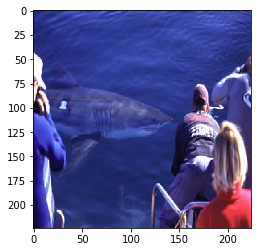

In [74]:
k = 301

pp.displayImage(x_val[k])
#PRINT PREDICTION CLASSES
print(pp.topClasses(predictions[k], encoder.classes_))

#LOAD PREDICTIONS INTO DATAFRAME, compute accuracy
def predictionsToDataframe(predictions, truth, encoder):
    one = []
    two = []
    three = []
    for p in predictions:
        top = pp.topClasses(p, encoder.classes_)
        one.append(top[0][0])
        two.append(top[1][0])
        three.append(top[2][0])
        
    df = pd.DataFrame({'truth': [pp.translateID(x) for x in encoder.inverse_transform(truth)],
                      'one': one,
                      'two': two,
                      'three': three}) 

    return df

df = predictionsToDataframe(predictions, y_val, encoder)

In [80]:
acc = len(df[df.truth == df.one])/len(df)
print("Top-1 accuracy: {0}".format(acc))

acc = len(df[(df.truth == df.one) | (df.truth == df.two)])/len(df)
print("Top-2 accuracy: {0}".format(acc))

acc = len(df[(df.truth == df.one) | (df.truth == df.two) | (df.truth == df.three) ]) / len(df)
print("Top-3 accuracy: {0}".format(acc))

# df.iloc[504]

Top-1 accuracy: 0.24957199923910975
Top-2 accuracy: 0.3608521970705726
Top-3 accuracy: 0.42914209625261557


Steps
1. Parse Image Data for all folders that you want to train on
2. Load in each batch and repeat:
    3. Apply augments to batch, if any
    4. Train batch
5. Evaluate model. 

# BATCH SELECTION

In [305]:
f = h5py.File(os.path.join(pp.h5Path, h5filename), 'r')
train_x = f['x_train']
train_y = f['y_train']
batch_size = 50

idxs = np.random.permutation(len(train_x))
batches = utils.chunks(idxs, batch_size)
batches_sorted = [np.sort(b) for b in batches]



In [315]:
x = train_x[list(batches_sorted[0])]
y = train_y[list(batches_sorted[0])]

goldfish, Carassius auratus


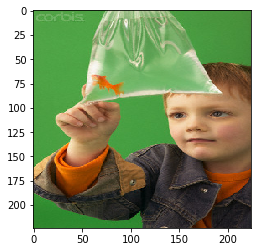

In [318]:
pp.displayImage(x[1])
print(pp.translateID(y[1].decode('utf-8')))

In [317]:
y

array([b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01491361', b'n01491361', b'n01491361', b'n01491361',
       b'n01491361', b'n01491361', b'n01491361', b'n01491361',
       b'n01491361', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01440764', b'n01440764',
       b'n01440764', b'n01440764', b'n01440764', b'n01440764',
       b'n01440764', b'n01440764', b'n01440764', b'n01484850',
       b'n01484850', b'n01484850', b'n01484850', b'n01484850',
       b'n01484850', b'n01484850'], dtype='|S9')

In [ ]:
class DataGenerator():
    
    def __init__

# Graphs

In [78]:
results.history

{'loss': [0.5523953437805176], 'acc': [0.875]}

In [100]:
outputPath = os.path.join('output','saved-models')

modelsFrom100 = []
val_scores = []

modelsFrom100.append(os.path.join(outputPath, "model-0-7-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-1-6-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-2-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-3-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-4-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-5-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-6-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-7-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-8-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-9-1-.h5"))

# x_val = val_x[:]
# y_val = val_y[:]
# y_val = [y.decode('utf-8') for y in y_val]
# y_val = encoder.fit_transform(y_val)

# val_scores = model1.evaluate(np.array(x_val), np.array(y_val))
for modelName in modelsFrom100:
    model = load_model(modelName)
    val_scores.append(model.evaluate(np.array(x_val), np.array(y_val)))
    
val_scores
# print(model1)
# print(model1loaded)

10514/10514 [==============================] - 14s 1ms/step


[[3.4991698467348247, 0.16283051169868745],
 [3.08843700899832, 0.23949020354664324],
 [2.918062787875037, 0.28143427810609195],
 [2.915889410412944, 0.29037473845248307],
 [3.0873023972938514, 0.28742628875926396],
 [3.4732818409406527, 0.2758227125751285],
 [3.827974426943652, 0.2684991439998955],
 [4.3541993239498735, 0.2660262507147519],
 [4.835062457645758, 0.26127068671194664],
 [5.257831900387815, 0.24957199924761336]]

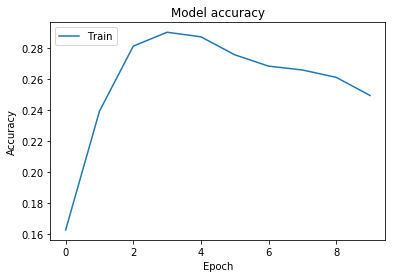

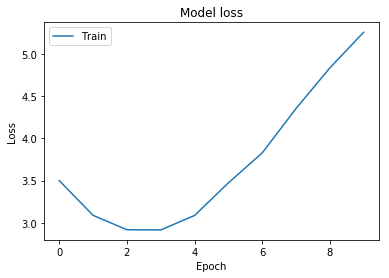

In [101]:
val_scores_acc = []
val_scores_loss = []
for i in val_scores:
    val_scores_acc.append(i[1])
    val_scores_loss.append(i[0])

# Plot training & validation accuracy values
plt.plot(val_scores_acc)
# plt.plot(results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(val_scores_loss)
# plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
# plt.ylim(0, 0.7)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()